### Тематическое моделирование

Мы уже использовали снижение размерности пространства при анализе текстов. Еще одним вариантом такого снижения является тематическое моделирование. Для него используются следующие рассуждения.

Пусть дан набор текстов, в каждом тексте имеются определенные слова. В таком случае можно посчитать матрицу термины-документы, в которой по строкам будут идти термины, по столбцам документы, а на пересечении будет стоять частота термина в данном документе. При помощи элементарных математических преобразований (метод SVD) данную матрицу можно представить в виде произведения трех матриц: матрицы слово на тематику, матрицы тематик и матрицы тематика на документ. Средняя из матриц будет квадратной и диагональной и будет содержать некоторые коэффициенты важности, которые можно отсортировать по убыванию. В этом случае размерность матрицы можно серьезно сократить, отбросив неактуальные темы.

<img  width="40%" src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Singular-Value-Decomposition.svg/1024px-Singular-Value-Decomposition.svg.png"> 
<img  width="40%" src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Singular_value_decomposition_visualisation.svg/800px-Singular_value_decomposition_visualisation.svg.png">

На основе SVD работает метод латентно-семантического анализа (LSA), который позволяет более четко найти связи между терминами и документами. Его более быстрая реализация, LDA, проводит нечеткий поиск. LSI является модификацией для задач информационного поиска.

Рассмотрим теперь пример применения SVD для задач классификации.

In [1]:
import pandas as pd
import numpy as np

import pymorphy2
import re
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

# Разложение матрицы на три с сокращением размерности.
from sklearn.decomposition import TruncatedSVD

Возьмем по тысяче научных текстов из пяти разных областей науки. (Они занимают 140 Мб и не влезают на Гит, так что доступны по запросу.)

In [2]:
sci_texts = pd.read_csv("/home/edward/papers/kourses/Advanced Python/DataGym/DataGym-02/09_w2v/data/kaggle-science-texts_train.tsv", header=0, sep = ';')

In [3]:
%%time
# Считаем матрицу термин-документ, но не с частотами, а со значениями Tf*Idf
X = TfidfVectorizer().fit_transform(sci_texts['Text'])
# Проводим SVD-разложение по 20 компонентам.
svd = TruncatedSVD(n_components=20)
X2 = svd.fit_transform(X)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))
print(X2.shape, X2)

Explained variance of the SVD step: 8%
(5000, 20) [[ 0.18716104  0.0564181  -0.09602505 ... -0.0735169   0.04410761
  -0.07244176]
 [ 0.15355927 -0.00178662 -0.06001305 ...  0.00531127  0.01767094
   0.01280711]
 [ 0.12449795  0.01570695 -0.06642658 ... -0.03566378 -0.02834059
  -0.06630837]
 ...
 [ 0.27208788 -0.08811322 -0.0622994  ... -0.07771276  0.04355847
   0.01014199]
 [ 0.16188171 -0.07406504 -0.0423278  ... -0.05127353  0.02770429
   0.01713832]
 [ 0.33845172 -0.1552291  -0.07595811 ... -0.06532984  0.0980997
  -0.00221686]]
CPU times: user 16.7 s, sys: 11.4 s, total: 28.1 s
Wall time: 13.7 s


Исходно, код ниже выполнялся 37 минут. Но если поставить<br>
`pip install pymorphy2[fast]`<br>
то библиотека начинает работать горазо быстрее.

Если морфология работает медленно, но в тексте вссегда есть повторяющиеся слова (помните закон Ципфа?), то может быть результаты медленной морфологии надо кешировать в быстром словаре (dict)?

In [4]:
# Список значимых частей речи. 
# Они нам потом понадобятся в немного другом виде. Так что сделаем словарь. чтобы два раза не вставать.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 
            'VERB':'VERB', 'PRTF':'ADJ', 'PRTS':'ADJ', 'GRND':'VERB'}

tmp_dict = {} # Кеш значимых слов.
nones = {} # Кеш незначимых слов.

morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy(text, need_pos=True):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        # Если токен уже был закеширован, быстро возьмем результат из него.
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        # Аналогично, если он в кеше незначимых слов.
        elif t in nones.keys():
            pass
        # Слово еще не встретилось, будем проводить медленный морфологический анализ.
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    if need_pos:
                        word = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                    else:
                        word = pv[0].normal_form
                    # Отправляем слово в результат, ...
                    words.append(word)
                    # ... и кешируем результат его разбора.
                    tmp_dict[t] = word
                else:
                    # Для незначимых слов можно даже ничего не хранить. Лишь бы потом не обращаться к морфологии.
                    nones[t] = ""
                    
    return words

In [5]:
%%time
sci_texts['NText'] = sci_texts['Text'].map(lambda x:' '.join(normalizePymorphy(x)))

CPU times: user 34.6 s, sys: 72.6 ms, total: 34.7 s
Wall time: 34.7 s


In [6]:
classes = np.ones(5000)
classes[1000:2000] = 2
classes[2000:3000] = 3
classes[3000:4000] = 4
classes[4000:] = 5

In [7]:
#Обучаем классификатор и оцениваем точность результатов.
X_train, X_test, y_train, y_test = train_test_split(X2, classes, test_size=0.2, random_state=333)
tree = RandomForestClassifier(criterion='entropy', random_state=333)
tree.fit(X_train, y_train)
y_hat=tree.predict(X_test)
print((len([1 for i, j in zip(y_hat, y_test) if i==j])/len(y_test)))
confusion_matrix(y_test, y_hat)

0.976


array([[203,   0,   4,   1,   1],
       [  2, 183,   4,   1,   0],
       [  2,   0, 202,   2,   0],
       [  0,   1,   1, 189,   2],
       [  0,   0,   0,   3, 199]])

Проведем аналогичные операции, но для лемматизированных текстов.

In [8]:
%%time
X = TfidfVectorizer().fit_transform(sci_texts['NText'])
svd = TruncatedSVD(n_components=10)
X2 = svd.fit_transform(X)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))


Explained variance of the SVD step: 9%
CPU times: user 6.41 s, sys: 6.47 s, total: 12.9 s
Wall time: 5.07 s


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X2, classes, test_size=0.2, random_state=333)
tree = RandomForestClassifier(criterion='entropy', random_state=333)
tree.fit(X_train, y_train)
y_hat=tree.predict(X_test)
print(len([1 for i, j in zip(y_hat, y_test) if i==j])/len(y_test))
confusion_matrix(y_test, y_hat)

0.973


array([[205,   2,   2,   0,   0],
       [  2, 182,   5,   1,   0],
       [  4,   3, 196,   2,   1],
       [  0,   1,   2, 188,   2],
       [  0,   0,   0,   0, 202]])

А тепеь посмотрим как будет работать тот же метод без SVD.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.2, random_state=333)
tree = RandomForestClassifier(criterion='entropy', random_state=333)
tree.fit(X_train, y_train)
y_hat=tree.predict(X_test)
print(len([1 for i, j in zip(y_hat, y_test) if i==j])/len(y_test))
confusion_matrix(y_test, y_hat)

0.97


array([[201,   0,   3,   2,   3],
       [  4, 180,   6,   0,   0],
       [  3,   0, 200,   2,   1],
       [  1,   0,   0, 190,   2],
       [  0,   0,   0,   3, 199]])

Для тематического моделирования текстов существует большая библиотека [BigARTM](http://bigartm.org/), но она не ставится так просто и не входит в стандартные библиотеки.

# Методы семантического анализа текстов

## Сходство между словами

You shall know a word by the company it keeps. 

*Frith*

 Варкалось. Хливкие шорьки<br>
   Пырялись по наве,<br>
   И хрюкотали зелюки,<br>
   Как мюмзики в мове.<br>

*Кэррол*

Не очень ясно что именно могут делать *зелюки*. Но если мы узнаем кто еще может *хрюкотать*, то мы можем посчитать, что нашли слово со сходным значением или, как минимум, относящееся к одной смысловой группе.

Аналогично мы не понимаем кто (что) такие *шорьки*. Если они бывают ответственными - это одно, если электронными - другое.

Модель описана в статье [Т.Миколова и др.](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Идея метода основывается на оптимизации функционала, основанного на логарифмах вероятностей совместной встречаемости слов. Помимо этого, вводятся отрицательные примеры, вероятности которых не суммируются, а вычитаются. При этом отрицательных примеров берется больше, чем положительных.

- Возьмем текст и разделим его на слова, выделим слова со значимыми частями речи.
- Пройдемся по всем словам текста. Возьмем несколько соседних слов справа и слева от текущего. Посчитаем частоты их совместной встречаемости.
- Отсеем все слова, которые встречаются слишком редко или с малым количеством других слов.

In [11]:
import pandas as pd
import re
import nltk
import nltk.data
from tqdm.notebook import tqdm

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/edward/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
with open("data/lenta2018.txt", encoding="utf-8") as newsfile: # Файл с новостями.
    text = newsfile.read()
    div_text = text.split("=====\n")[1:]
    text_news = [(n.split('\n')[0], '\n'.join(n.split('\n')[2:])) 
                 for n in div_text]
    news = pd.DataFrame(text_news, columns = ['Header', 'News'])

In [13]:
news.head()

,Header,News
0,Раскрыто происхождение новейшей украинской кры...,Испытанная Украиной первая собственная крылата...
1,Русских гопников назвали настоящими древними с...,Пользователи Reddit выразили симпатию российск...
2,Поезд с американскими политиками врезался в му...,В американском штате Вирджиния пассажирский по...
3,Открыт первый европейский бордель с секс-кукла...,"Во Франции открылся первый бордель, который сд..."
4,Социологи подсчитали планирующих проголосовать...,На выборы президента собирается прийти 71 проц...


Давайте поделим тексты на предложения, а предложения на слова

In [14]:
def text_to_sentences(text):
    sentences = []
    tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')
    raw_sentences = tokenizer.tokenize(text.strip())
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(re.sub('[^a-zA-Zа-яА-яёЁ]', ' ', raw_sentence).lower().split())
    return sentences

In [15]:
text_to_sentences(news['News'][11])

[['ракета',
  'носитель',
  'союз',
  'а',
  'с',
  'спутниками',
  'стартовала',
  'с',
  'космодрома',
  'восточный'],
 ['об',
  'этом',
  'сообщает',
  'космический',
  'центр',
  'южный',
  'который',
  'ведет',
  'прямую',
  'трансляцию',
  'запуска',
  'корабль',
  'должен',
  'доставить',
  'на',
  'орбиты',
  'спутников',
  'два',
  'из',
  'которых',
  'российские',
  'спутники',
  'дистанционного',
  'зондирования',
  'земли',
  'канопус',
  'в',
  'и',
  'это',
  'уже',
  'третий',
  'пуск',
  'с',
  'восточного'],
 ['предыдущий',
  'состоялся',
  'ноября',
  'года',
  'и',
  'завершился',
  'неудачей',
  'из',
  'за',
  'неполадок',
  'с',
  'разгонным',
  'блоком',
  'была',
  'утеряна',
  'головная',
  'часть',
  'ракеты',
  'союз',
  'б',
  'с',
  'спутниками',
  'на',
  'борту'],
 ['в',
  'госкорпорации',
  'роскосмос',
  'объяснили',
  'инцидент',
  'ошибкой',
  'в',
  'программном',
  'обеспечении',
  'разгонного',
  'блока',
  'и',
  'ракеты',
  'носителя',
  'заложе

In [16]:
news['News'][0]

'Испытанная Украиной первая собственная крылатая ракета создана КБ «Луч» в рамках ОКР «Нептун» на основе российской противокорабельной ракеты 3М24 комплекса Х-35У. Об этом пишет военный блог bmpd, который ведут сотрудники московского Центра анализа стратегий и технологий.«Напомним, что в советский период серийное производство ракет 3М24 (Х-35) планировалось организовать на Харьковском авиационном заводе (нынешнее ХГАПП), так что на Украине имеется, видимо, полный комплект производственно-конструкторской документации на эту ракету, как и ведется производство ее двигателя», — отметили эксперты.Разработчиком противокорабельной ракеты 3М24 комплекса «Уран» выступает головное предприятие АО «Корпорация Тактическое ракетное вооружение» (бывшее ГНПЦ «Звезда-Стрела»), расположенное в подмосковном Королёве.Аналитики, ссылаясь на имеющиеся фото- и видеоматериалы тестов, полагают, что Украина провела бросковые испытания макета ракеты, у которого был отключен турбореактивный двигатель и отсутствов

In [17]:
all_sentences = sum([text_to_sentences(x) for x in news['News']], [])

In [18]:
all_sentences[0]

['испытанная',
 'украиной',
 'первая',
 'собственная',
 'крылатая',
 'ракета',
 'создана',
 'кб',
 'луч',
 'в',
 'рамках',
 'окр',
 'нептун',
 'на',
 'основе',
 'российской',
 'противокорабельной',
 'ракеты',
 'м',
 'комплекса',
 'х',
 'у']

## Модель Word2Vec

In [19]:
# Импортируем библиотеки Word2Vec
from gensim.models.word2vec import Word2Vec # Собственно модель.
from gensim.models import KeyedVectors # Семантические вектора.

### Использование предобученных моделей

Теперь загрузим модель, обученную разработчиками проекта <a href="http://rusvectores.org/ru/models/">RusVectores</a> для русского языка на новостях. В зависимости от того, откуда вы берете модели, они могут загружаться по-разному. Более того, модель можно обучить самому - для этого нужно просто взять много размеченных текстов.

In [22]:
model_w2v = KeyedVectors.load_word2vec_format('data/araneum_upos_skipgram_300_2_2018.vec.gz')

Теперь можно получить представление слов в новом пространстве. Имейте в виду, что в данной модели они идут с частями речи!

In [23]:
model_w2v['огонь_NOUN']

array([-2.69010e-02,  1.08851e-01,  1.13100e-03, -2.76620e-02,
       -2.50680e-02, -4.58600e-03, -1.26100e-03, -3.79600e-03,
       -7.53080e-02, -2.39490e-02,  2.00400e-02,  6.10330e-02,
        7.40810e-02,  9.56330e-02, -1.11446e-01,  4.60380e-02,
       -2.24540e-02, -2.46080e-02, -8.82250e-02, -1.53180e-02,
       -3.66000e-04, -9.46770e-02,  1.33686e-01,  5.88400e-03,
       -5.05470e-02,  8.13820e-02, -2.88090e-02, -7.00070e-02,
        8.74950e-02, -8.31860e-02, -2.48210e-02, -3.82660e-02,
        6.13210e-02, -6.45530e-02,  2.66400e-03,  8.36140e-02,
       -3.73850e-02,  3.63260e-02, -1.20000e-04, -6.90000e-02,
        1.49810e-02,  3.03880e-02, -2.17280e-02,  2.79400e-02,
       -5.22550e-02,  1.96660e-02,  1.52499e-01,  7.27100e-02,
       -2.11140e-02,  5.69930e-02, -3.07870e-02,  4.09070e-02,
        6.49290e-02,  1.91730e-02,  2.50080e-02, -2.94090e-02,
        6.33780e-02,  1.09028e-01,  5.66630e-02, -3.62330e-02,
        4.96900e-02, -7.09280e-02,  2.74420e-02, -1.986

In [46]:
model_w2v.most_similar('интернет_NOUN')

[('интеренет_NOUN', 0.924296498298645),
 ('интерент_NOUN', 0.9155471920967102),
 ('интренет_NOUN', 0.9038118720054626),
 ('интрнет_NOUN', 0.8466425538063049),
 ('итернет_NOUN', 0.834010660648346),
 ('интенета_NOUN', 0.8012408018112183),
 ('инетрнет_NOUN', 0.7921422719955444),
 ('интерет_NOUN', 0.786211371421814),
 ('инетернет_NOUN', 0.7794284224510193),
 ('интернт_NOUN', 0.7663599252700806)]

In [25]:
model_w2v.most_similar('ученый_NOUN')

[('исследователь_NOUN', 0.8123084902763367),
 ('биолог_NOUN', 0.7502084374427795),
 ('астрофизик_NOUN', 0.7438788414001465),
 ('ученый_ADJ', 0.7298716306686401),
 ('нейрофизиолог_NOUN', 0.7224255204200745),
 ('нейробиолог_NOUN', 0.7219529151916504),
 ('климатолог_NOUN', 0.7159756422042847),
 ('зоолог_NOUN', 0.7055575251579285),
 ('астроном_NOUN', 0.7006036639213562),
 ('палеонтолог_NOUN', 0.6994451880455017)]

В пространстве Word2Vec возможны векторные операции. Попробуем их.

In [26]:
#model_w2v.most_similar(positive=[u'пожар_NOUN'])
#model_w2v.most_similar(positive=[u'пожар_NOUN'], negative=[u'пламя_NOUN' ])
#model_w2v.most_similar(positive=[u'топливо_NOUN', u'молоко_NOUN'], negative=[u'нефть_NOUN' ])
#model_w2v.most_similar(positive=[u'женщина_NOUN', u'император_NOUN' ], negative=[u'мужчина_NOUN'])
model_w2v.most_similar(positive=[u'король_NOUN', u'женщина_NOUN'], negative=[u'мужчина_NOUN'])
#model_w2v.most_similar(positive=[u'президент_NOUN', u'женщина_NOUN'], negative=[u'мужчина_NOUN'])
# model_w2v.most_similar(negative=[u'король_NOUN', u'мужчина_NOUN'], positive=[u'женщина_NOUN'])
# model_w2v.most_similar(positive=[u'король_NOUN', u'мужчина_NOUN'], negative=[u'женщина_NOUN'])
#model_w2v.most_similar(positive=[u'женщина_NOUN', u'король_NOUN' ])
#model_w2v.most_similar(positive=[u'берлин_PROPN', u'москва_PROPN' ], negative=[u'германия_PROPN'])


[('королева_NOUN', 0.7022064328193665),
 ('герцог_NOUN', 0.6763379573822021),
 ('монарх_NOUN', 0.6703874468803406),
 ('генрих_PROPN', 0.656510055065155),
 ('людовик_PROPN', 0.656411349773407),
 ('франция::людовик_PROPN', 0.6421706080436707),
 ('принц_NOUN', 0.6407060027122498),
 ('королевство_NOUN', 0.6257355809211731),
 ('наследный_ADJ', 0.6177536845207214),
 ('герцогиня_NOUN', 0.617081344127655)]

Можно найти лишнее слово в последовательности.

In [27]:
model_w2v.doesnt_match(['лук_NOUN', 'перец_NOUN', 'ученик_NOUN', 'плодовый_ADJF'])

'ученик_NOUN'

Итак, вместо самих слов мы можем использовать их векторные представления в некотором семантическом пространстве.

<img src="img/cartoon-espresso-word2vec.jpg">

Беда Word2Vec состоит в том, что он генерирует только один вектор на каждое слово. То есть он не различает различных смыслов одного слова.

<img src="img/cartoon-citizen-data-scientist.jpg">

Можно провести аналогию с SVD. У нас строится некоторое пространство, размерность которого определяется числом латентных переменных в системе - скрытых параметров, каждый из которых отвечает за какой-то "смысл": размер, цвет, политика, время, абстрактность, падеж слова и прочее.

Количество признаков в этом пространстве определяется числом подобных скрытых переменных.

В полученном пространстве работают векторные операции. Если обучиться на достаточно большом количестве текстов, можно получить следующие эффекты.

![](img/w2v_vect.png)

![](img/w2v_vect2.png)



На хорошо обученной модели можно даже превратить индекс в город и наоборот при помощи векторных операций.

Давайте посмотрим на реальное расположение слов в этом пространстве. Для этого нам потребуется UMAP, а то как еще мы преобразуем 300-мерное пространство в плоскость?

In [28]:
from umap import UMAP
from copy import copy

%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 12)

In [30]:
trees = pd.read_csv("data/trees.txt", sep='\t', names=['trees'])
herbs = pd.read_csv("data/herbs.txt", sep='\t', names=['herbs'])
trees = trees['trees'].str.lower().unique()
herbs = herbs['herbs'].str.lower().unique()

In [32]:
men_avg, women_avg = np.zeros(model_w2v.vector_size), np.zeros(model_w2v.vector_size)
men_count, women_count = 0, 0
men_vect, women_vect, animal_type, animal_no = [], [], [], []
dif_vect = []
names = []
men_names, women_names = [], []

for m in trees:
    if m.strip().lower()+'_NOUN' in model_w2v.key_to_index.keys():
        mv = model_w2v[m.strip().lower()+'_NOUN']
        men_avg += mv
        men_count += 1
        men_vect.append(mv)
        men_names.append(m)
        animal_type.append(1)
        
for w in herbs:
    if w.strip().lower()+'_NOUN' in model_w2v.key_to_index.keys():
        wv = model_w2v[w.strip().lower()+'_NOUN']
        women_avg += wv
        women_count += 1
        women_vect.append(wv)
        women_names.append(w)
        animal_type.append(0)

        
for i in range(men_count):
    mv = men_vect[i]
    animal_no.append(i)
    for j in range(women_count):
        wv = women_vect[j]
        dif_vect.append(mv - wv)
        names.append([men_names[i], women_names[j]])

men_avg /= men_count
women_avg /= women_count

dif_avg = men_avg - women_avg
cosines = KeyedVectors.cosine_similarities(dif_avg, dif_vect)

#print(list(zip(names, cosines)))
print([(n, c) for n, c in list(zip(names, cosines)) if c>0.6])

[(['клен', 'маргаритка'], 0.6117089698392721), (['клен', 'настурция'], 0.6115848257569042), (['клен', 'дельфиниум'], 0.6010003968890965), (['черешня', 'щавель'], 0.6182821208457462), (['черешня', 'редис'], 0.6446437627648164), (['самшит', 'настурция'], 0.6133552135715983), (['сосна', 'настурция'], 0.6001034566353993)]


/home/edward/.local/lib/python3.9/site-packages/gensim/models/keyedvectors.py:1082: RuntimeWarning: invalid value encountered in true_divide
  similarities = dot_products / (norm * all_norms)


In [33]:
all_vect, all_names = copy(men_vect), copy(men_names)
all_vect.extend(women_vect)
all_names.extend(women_names)

umaped_vct=UMAP().fit_transform(all_vect)

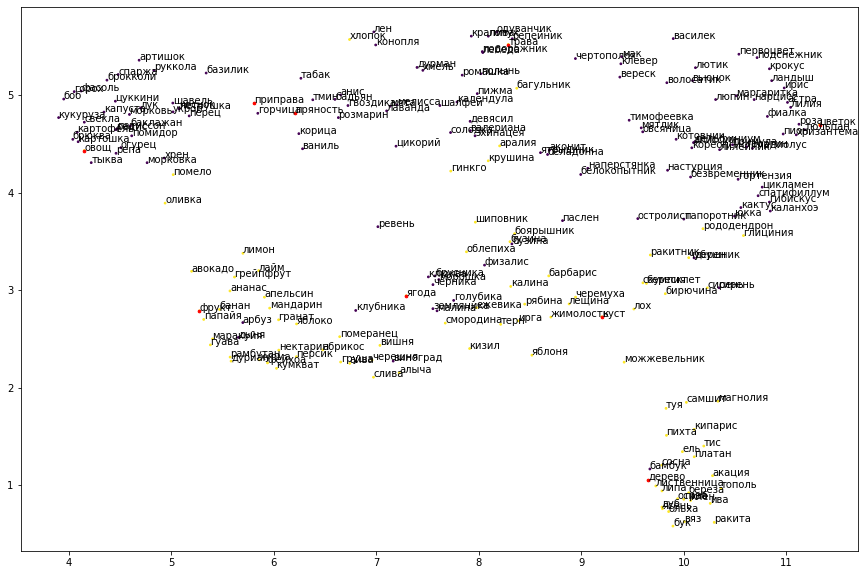

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], c=animal_type, s=3)

for word in ['фрукт', 'овощ', 'ягода', 'приправа', 'пряность', 'дерево', 'трава', 'цветок', 'куст']:
    ind = all_names.index(word)
    ax.scatter(umaped_vct[ind, 0], umaped_vct[ind, 1], c='r', s=7)

for n, v in zip(all_names, umaped_vct):
    ax.annotate(n, (v[0], v[1]))

plt.show()

А теперь давайте добавим ещё одно измерение и посмотрим, как точки будут меняться вдоль него.

In [35]:
from ipywidgets import interact, FloatSlider

In [36]:
all_vect, all_names = copy(men_vect), copy(men_names)
all_vect.extend(women_vect)
all_names.extend(women_names)

umaped_vct=UMAP(n_components=3).fit_transform(all_vect)

In [37]:
def drawHerbs(val):
    fig, ax = plt.subplots()
    fig.set_size_inches(15,10)
    temp_data = np.array([u for u in umaped_vct if u[2]>=val-0.5 and u[2]<=val+0.5])
    temp_names = [all_names[i] for i, u in enumerate(umaped_vct) if u[2]>=val-0.5 and u[2]<=val+0.5]
    
    ax.scatter(temp_data[:, 0], temp_data[:, 1], c=temp_data[:, 2], s=30)

    for word in ['фрукт', 'овощ', 'ягода', 'приправа', 'пряность', 'дерево', 'трава', 'цветок', 'куст']:
        ind = all_names.index(word)
        ax.scatter(umaped_vct[ind, 0], umaped_vct[ind, 1], c='r', s=7)
        ax.annotate(word, (umaped_vct[ind, 0], umaped_vct[ind, 1]))

    for n, v in zip(temp_names, temp_data):
        ax.annotate(n, (v[0], v[1]))

    plt.show()

In [38]:
sld1 = FloatSlider(value=(min(umaped_vct[:, 2])+max(umaped_vct[:, 2]))/2, min=min(umaped_vct[:, 2]), max=max(umaped_vct[:, 2]), step=0.1, description='Filter by Z')

interact(drawHerbs, val=sld1);

interactive(children=(FloatSlider(value=4.095809459686279, description='Filter by Z', max=7.391615390777588, m…

### Обучение собственной модели в Word2Vec


In [40]:
%%time

# список параметров, которые можно менять по вашему желанию
num_features = 300  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 3     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели

model_our_news = Word2Vec(all_sentences, workers=num_workers, vector_size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

CPU times: user 2.24 s, sys: 30 ms, total: 2.27 s
Wall time: 890 ms


Возьмем по тысяче научных текстов из пяти разных областей науки.

In [41]:
sci_sentences = []
for text in tqdm(sci_texts.Text):
#     sci_sentences.extend(normalizePymorphy(text))
    sci_sentences.append(normalizePymorphy(text))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [43]:
%%time

# список параметров, которые можно менять по вашему желанию
num_features = 50  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 4     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели

model_our_sci = Word2Vec(sci_sentences, workers=num_workers, vector_size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

CPU times: user 1min 17s, sys: 170 ms, total: 1min 17s
Wall time: 21.3 s


In [44]:
# Финализируем нашу модель. Ее нельзя будет доучить теперь, но она начнет занимать гораздо меньше места
model_our_sci.init_sims(replace=True)

/tmp/ipykernel_393799/2369989797.py:2: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model_our_sci.init_sims(replace=True)


In [47]:
# Посмотрим на самые похожие слова.
model_our_sci.wv.most_similar('продукт_NOUN'), model_our_sci.wv.most_similar('система_NOUN')

([('продукция_NOUN', 0.6289545893669128),
  ('медиаконтент_NOUN', 0.6270601749420166),
  ('сырьё_NOUN', 0.5863563418388367),
  ('жир_NOUN', 0.5813148021697998),
  ('медиапродукт_NOUN', 0.5774102807044983),
  ('антиокислитель_NOUN', 0.5677422285079956),
  ('биокорректор_NOUN', 0.5668464303016663),
  ('концентрат_NOUN', 0.55882728099823),
  ('ингредиент_NOUN', 0.5541642904281616),
  ('мороженое_NOUN', 0.5513280630111694)],
 [('подсистема_NOUN', 0.7643614411354065),
  ('взаимозависимый_ADJ', 0.669556200504303),
  ('взаимосвязанный_ADJ', 0.6690719127655029),
  ('целостность_NOUN', 0.6652218103408813),
  ('непрерывный_ADJ', 0.6517024040222168),
  ('управляемость_NOUN', 0.6176445484161377),
  ('вычислитель_NOUN', 0.6144310832023621),
  ('принцип_NOUN', 0.6038118004798889),
  ('единый_ADJ', 0.5970538258552551),
  ('интеграция_NOUN', 0.5959528088569641)])

In [48]:
model_our_sci.wv.most_similar('говорить_VERB')

[('казаться_VERB', 0.8168213963508606),
 ('видеть_VERB', 0.8029413819313049),
 ('пытаться_VERB', 0.7696641683578491),
 ('понимать_VERB', 0.7641817331314087),
 ('думать_VERB', 0.7526095509529114),
 ('знать_VERB', 0.7517363429069519),
 ('хотеть_VERB', 0.7436938285827637),
 ('всякий_ADJ', 0.7359464764595032),
 ('отказываться_VERB', 0.7250635027885437),
 ('никакой_ADJ', 0.7158330678939819)]

In [49]:
model_our_sci.wv.most_similar('ученик_NOUN')

[('учитель_NOUN', 0.8137716054916382),
 ('ребята_NOUN', 0.7990027070045471),
 ('воспитатель_NOUN', 0.788260817527771),
 ('мастерская_NOUN', 0.7443253993988037),
 ('родитель_NOUN', 0.7413150668144226),
 ('учиться_VERB', 0.7411839365959167),
 ('педагог_NOUN', 0.7202627062797546),
 ('учить_VERB', 0.7133998870849609),
 ('взрослый_ADJ', 0.7080497145652771),
 ('сверстник_NOUN', 0.7035991549491882)]

In [50]:
model_our_sci.wv.most_similar('орех_NOUN')

[('грецкий_ADJ', 0.9370299577713013),
 ('перец_NOUN', 0.908236026763916),
 ('морковь_NOUN', 0.903785228729248),
 ('лук_NOUN', 0.9019426107406616),
 ('репчатый_ADJ', 0.901341438293457),
 ('сушёный_ADJ', 0.8890944719314575),
 ('вишня_NOUN', 0.8879370093345642),
 ('тыква_NOUN', 0.8855022192001343),
 ('чеснок_NOUN', 0.8849307894706726),
 ('кабачок_NOUN', 0.881115198135376)]

Можно найти лишнее слово в последовательности.

In [52]:
# Размер проанализированного корпуса
model_our_sci.corpus_total_words

7357193

Теперь вернемся к размеру векторов.

In [53]:
model_our_sci.vector_size

50

Посмотрим как будут отображаться растения на новой модели.

In [61]:
men_avg, women_avg = np.zeros(model_our_sci.vector_size), np.zeros(model_our_sci.vector_size)
men_count, women_count = 0, 0
men_vect, women_vect, animal_type, animal_no = [], [], [], []
dif_vect = []
names = []
men_names, women_names = [], []

for m in trees:
    try:
        mv = model_our_sci.wv[m.strip().lower()+'_NOUN']
        men_avg += mv
        men_count += 1
        men_vect.append(mv)
        men_names.append(m)
        animal_type.append(1)
    except:
        pass
        
for w in herbs:
    try:
        wv = model_our_sci.wv[w.strip().lower()+'_NOUN']
        women_avg += wv
        women_count += 1
        women_vect.append(wv)
        women_names.append(w)
        animal_type.append(0)
    except:
        pass
        
for i in range(men_count):
    mv = men_vect[i]
    animal_no.append(i)
    for j in range(women_count):
        wv = women_vect[j]
        dif_vect.append(mv - wv)
        names.append([men_names[i], women_names[j]])

men_avg /= men_count
women_avg /= women_count

dif_avg = men_avg - women_avg
cosines = KeyedVectors.cosine_similarities(dif_avg, dif_vect)

#print(list(zip(names, cosines)))
print([(n, c) for n, c in list(zip(names, cosines)) if abs(c)<0.001])

[(['персик', 'огурец'], -0.0008353215068758719), (['персик', 'клевер'], 0.0001223857354534455), (['пихта', 'папоротник'], -0.0002656573772307304), (['айва', 'клюква'], -0.0007184611815108578), (['абрикос', 'клевер'], -0.0006394714479603612), (['ананас', 'капуста'], -0.0002252143259624409), (['лимон', 'мак'], -0.00048759692500407374)]


/home/edward/.local/lib/python3.9/site-packages/gensim/models/keyedvectors.py:1082: RuntimeWarning: invalid value encountered in true_divide
  similarities = dot_products / (norm * all_norms)


In [62]:
all_vect, all_names = copy(men_vect), copy(men_names)
all_vect.extend(women_vect)
all_names.extend(women_names)

umaped_vct=UMAP().fit_transform(all_vect)

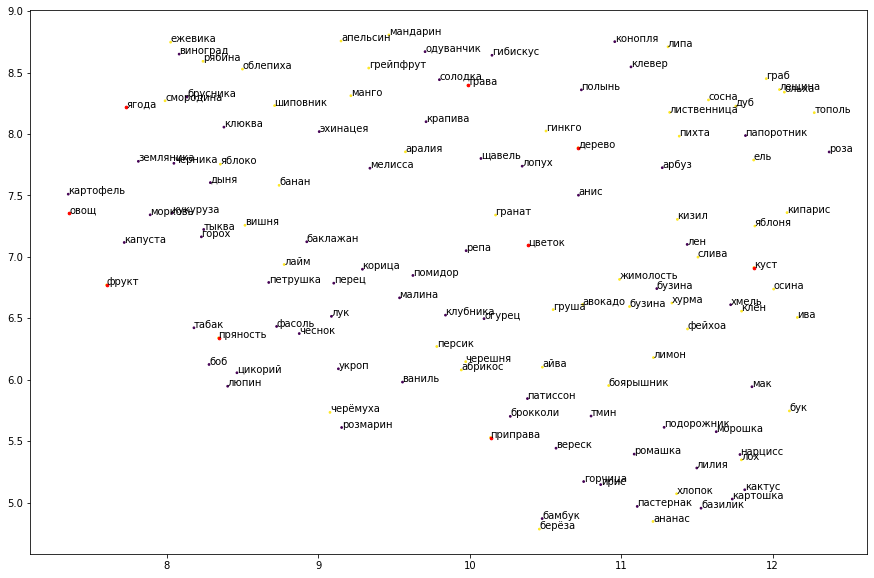

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], c=animal_type, s=3)

for word in ['фрукт', 'овощ', 'ягода', 'приправа', 'пряность', 'дерево', 'трава', 'цветок', 'куст']:
    ind = all_names.index(word)
    ax.scatter(umaped_vct[ind, 0], umaped_vct[ind, 1], c='r', s=7)

for n, v in zip(all_names, umaped_vct):
    ax.annotate(n, (v[0], v[1]))

plt.show()

----

Переразметим наши тексты так, чтобы они содержали в себе и часть речи, понятную загруженной модели.

In [65]:
# Список значимых частей речи.
conv_pos = {'ADJF':'ADJ', 'ADJS':'ADJ', 'ADV':'ADV', 'NOUN':'NOUN', 'VERB':'VERB'}

tmp_dict = {}
nones = {}

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy3(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        if t in tmp_dict.keys():
            words.append(tmp_dict[t])
        elif t in nones.keys():
            pass
        else:
            pv = morph.parse(t)
            if pv[0].tag.POS != None:
                if pv[0].tag.POS in conv_pos.keys():
                    words.append(pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS])
                    tmp_dict[t] = pv[0].normal_form+"_"+conv_pos[pv[0].tag.POS]
                else:
                    nones[t] = ""
                    
    return words

Теперь посмотрим какова размерность векторов, хранимых в модели, и сколько в ней слов.<br>
Размерность векторов 300 - с запасом. Почти 250 000 слов - тоже очень хорошо.

In [67]:
print(model_w2v.vector_size)
print(len(model_w2v.index_to_key))

300
196620


In [68]:
model_w2v.index_to_key[:50]

['год_NOUN',
 'мочь_VERB',
 'человек_NOUN',
 'время_NOUN',
 'работа_NOUN',
 'новый_ADJ',
 'становиться_VERB',
 'также_ADV',
 'очень_ADV',
 'день_NOUN',
 'первый_ADJ',
 'компания_NOUN',
 'являться_VERB',
 'ребенок_NOUN',
 'иметь_VERB',
 'система_NOUN',
 'место_NOUN',
 'получать_VERB',
 'большой_ADJ',
 'жизнь_NOUN',
 'вопрос_NOUN',
 'хороший_ADJ',
 'должный_ADJ',
 'вид_NOUN',
 'город_NOUN',
 'сайт_NOUN',
 'случай_NOUN',
 'дело_NOUN',
 'дом_NOUN',
 'сделать_VERB',
 'давать_VERB',
 'говорить_VERB',
 'россия_PROPN',
 'возможность_NOUN',
 'высокий_ADJ',
 'страна_NOUN',
 'область_NOUN',
 'мир_NOUN',
 'работать_VERB',
 'данный_ADJ',
 'начинать_VERB',
 'часть_NOUN',
 'качество_NOUN',
 'знать_VERB',
 'сказать_VERB',
 'позволять_VERB',
 'хорошо_ADV',
 'хотеть_VERB',
 'нужно_ADV',
 'принимать_VERB']

У нас есть смысл отдельных слов. Построим на его основе смысл текста как среднее арифметическое всех векторов для слов, составляющих данный текст.

In [71]:
index2word_set = set(model_w2v.index_to_key)

def text_to_vec(text):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model_w2v[word]) 
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec


Рассчитаем вектора всех текстов - они нам еще пригодятся.

In [72]:
w2v_vectors = [text_to_vec(text) for text in news.News]

Найдем текст, самый похожий на некоторый текст.

In [73]:
vpos = 71
v1 = text_to_vec(news.News[vpos])

ms = np.argmin([np.linalg.norm(v1-w2v_vectors[i]) for i in range(news.News.shape[0]) if i!=vpos])
print(ms, news.News[vpos])
if ms>vpos:
    print(ms+1, news.News[ms+1])
else:
    print(ms, news.News[ms])

1467 Один из крупнейших американских инвестиционных банков Merrill Lynch назвал акции «Роснефти» фаворитом среди нефтяных компаний EEMEA (Восточная Европа, Ближний Восток и Африка) и рекомендовал покупать их. Об этом говорится в исследовании инвестбанка «"Роснефть": Свободный денежный поток и дивиденды готовятся к рекордам в 2018 году. Рекомендуем покупать».Цены акций «Роснефти» за последние два месяца вернулись к росту, отмечается в комментарии инвестбанка. «Сильный свободный денежный поток в совокупности с ожидаемой по 2018 году дивидендной доходностью на уровне 7 процентов позволяют нам выделить акции "Роснефти" в качестве фаворитов среди нефтяных компаний EEMEA», — указали эксперты.В свои расчеты они включили платеж от АФК «Система», а также недавние приобретения «Роснефти». «В результате мы скорректировали наши ожидания по чистой прибыли и повысили целевую цену по акциям "Роснефти" на 6,3 процента, до 6,94 доллара за GDR, сохранив рекомендацию покупать», — отмечается в обзоре.В ис

Теперь посмотрим как разспределятся тексты в новом пространстве.

In [74]:
umap_news=UMAP()
umaped_vct=umap_news.fit_transform(w2v_vectors)

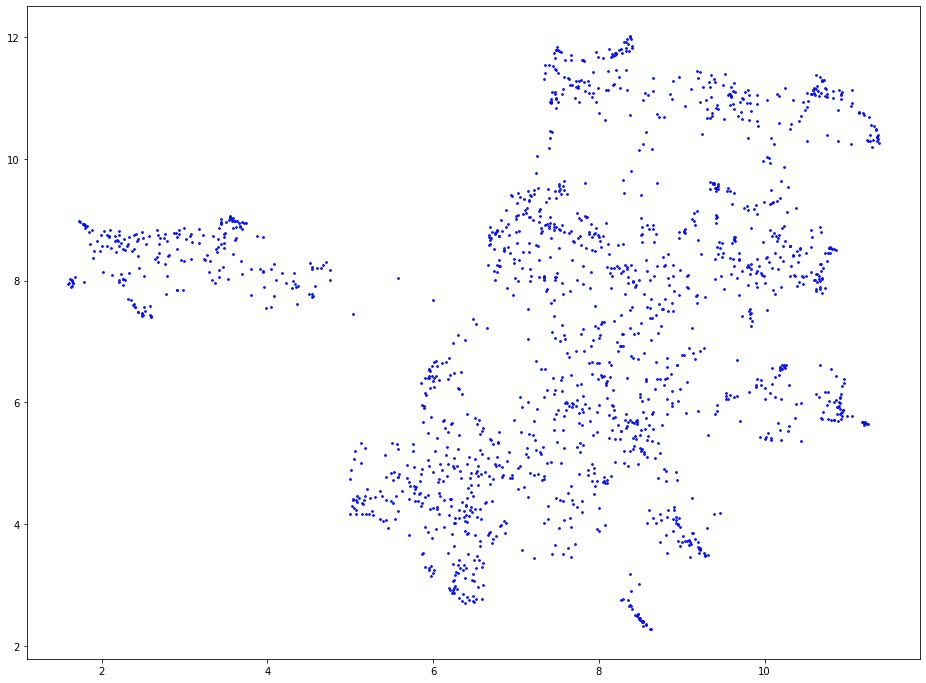

In [75]:
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

In [76]:
from sklearn.cluster import DBSCAN
import seaborn as sns
from matplotlib.colors import ListedColormap
from numpy.random import choice

Посмотрим что будет, если обучить на данных после преобразования пространства.

120


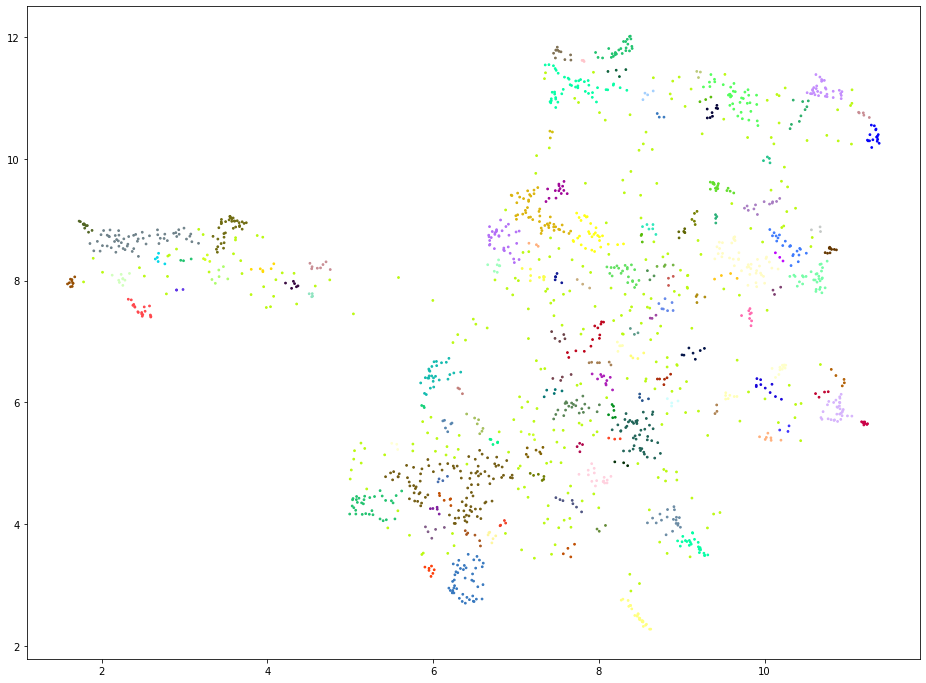

In [77]:
db=DBSCAN(eps=0.12, min_samples=3)
db_clusters=db.fit_predict(umaped_vct)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
plt.show()


In [78]:
clusters=list(set(db_clusters))

for c in clusters[:10]:
    print(c)
    cntr=0
    for i, a in enumerate(news.Header):
        if db_clusters[i]==c:
            print(a)
            cntr+=1
            if cntr==3:
                break

0
Раскрыто происхождение новейшей украинской крылатой ракеты
Китай испытал убийцу американских авианосцев
БМП-мутант заметили на сирийско-иракской границе
1
Русских гопников назвали настоящими древними славянами
Ушастый лисенок из России стал мировой знаменитостью
Ставший мемом дед Гарольд привязал к стулу доминирующую начальницу
2
Открыт первый европейский бордель с секс-куклами вместо проституток
Самый богатый китаец признал бесполезность денег
У зятя президента Туркмении нашли часы на миллион долларов
3
Социологи подсчитали планирующих проголосовать на выборах-2018
Украинцы утратили шансы на лучшую жизнь
Украина обогнала Россию по росту экономики
4
Названа причина исчезновения рыболовецкого судна «Восток»
Полный самолет сантехников вернулся в аэропорт из-за сломанного туалета
Путешественников из Нового Уренгоя подвез атомный ледокол
5
Учитель угодил под суд за оральный секс со спящим школьником
Самарский подросток объяснил желание напасть на школу
Школьница ради Слендермена попытала

Попробуем теперь провести кластеризацию в исходном пространстве.

Предварительно прикинем значение $\epsilon$ по расстоянию до ближайших соседей. Для этого используем функцию для построения графа k ближайших соседей из sklearn.

In [79]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans

In [80]:
# Строит разреженный граф, в котором на месте связей с ближайшими соседями стоят единицы.
wm = kneighbors_graph(w2v_vectors, 3, n_jobs=-1)

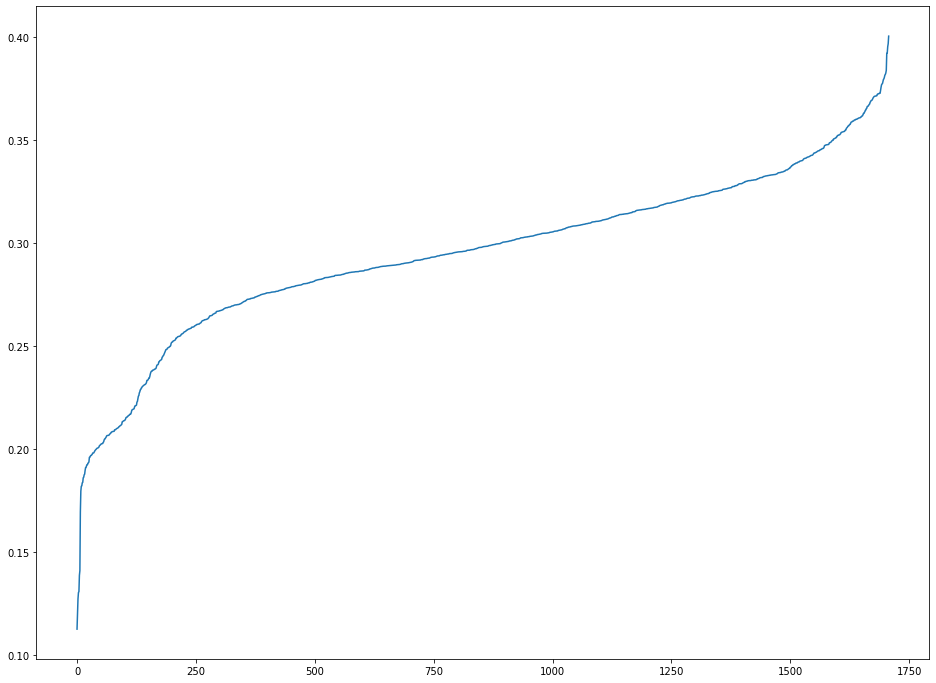

In [81]:
nzr, nzc = wm.nonzero()
neighbours = np.zeros(len(w2v_vectors))
for r, c in zip(nzr, nzc):
    neighbours[r] += np.linalg.norm(v1-w2v_vectors[c])
    
neighbours=sorted(neighbours/3)
fig, ax = plt.subplots()
ax.plot(range(len(neighbours)), neighbours)
plt.show()    

Теперь проведем кластеризацию.

27


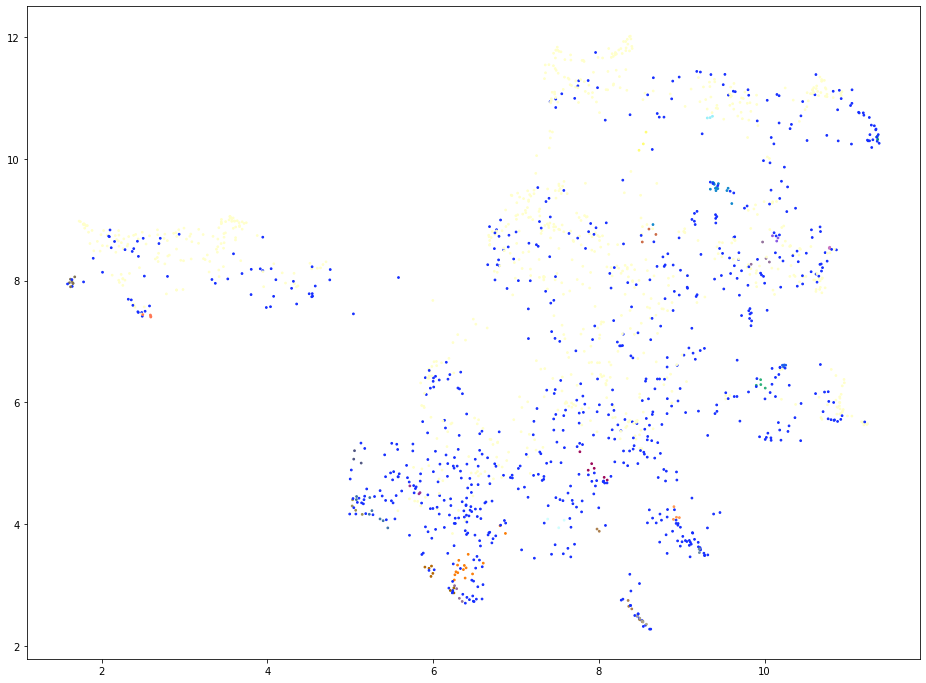

In [82]:
db=DBSCAN(eps=0.17, min_samples=3)
db_clusters=db.fit_predict(w2v_vectors)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
plt.show()

In [83]:
clusters=list(set(db_clusters))

for c in clusters[:10]:
    print(c)
    cntr=0
    for i, a in enumerate(news.Header):
        if db_clusters[i]==c:
            print(a)
            cntr+=1
            if cntr==3:
                break

0
Раскрыто происхождение новейшей украинской крылатой ракеты
Звезду сериала «Детективы» задержали за работу детектива
С космодрома Восточный запустили третью ракету
1
Социологи подсчитали планирующих проголосовать на выборах-2018
На выборы президента России пойдут почти 80 процентов избирателей
Грудинин уступил в популярности КПРФ
2
Найдены препараты против старения
Опровергнут главный миф об омоложении человека
Найдено предотвращающее старение вещество
3
Неймар заставит «Барселону» расплатиться
Роналду вошел в положение «Реала» и заслужил повышение зарплаты
Щуплость и конкуренция с Гатаговым избавили Неймара от карьеры в России
4
Американская супермодель обвинила соучредителя Guess в домогательствах
Жертва насильника придумала шорты для защиты от насильников
Номинант на «Оскар» заставил поклонников люкса предаться размышлениям
5
Названы самые погрязшие в сугробах районы столицы
В Москве оценили последствия рекордного снегопада
Минтруд дал совет опаздывающим на работу россиянам
6
В сет

Теперь вернемся к научным статьям.

При объединении всех векторов текста происходит размытие его смысла за счет того, что некоторые понятия хоть и являются близкими, но имеют различия. Вместо того, чтобы брать само слово, давайте объединим все слова одной группы и будем брать их центроид. Заодно посмотрим какие слова попадают в одну группу.

In [84]:
%%time
sci_texts['NText'] = sci_texts['Text'].map(lambda x:' '.join(normalizePymorphy(x)))

CPU times: user 32.7 s, sys: 71.5 ms, total: 32.8 s
Wall time: 32.8 s


In [85]:
%%time
dct = {}
# Бежим по статьям.
for article in sci_texts.NText:
    # Берем слово. Потом берем 4 соседа слева и справа.
    words = article.split(' ')
    for i, word1 in enumerate(words[4:-5]):
        for j, word2 in enumerate(words[i-4:i+4]):
            if i!=j:
                # Если основного слова еще не встречалось - добавляем его.
                if word1 not in dct.keys():
                    dct[word1] = {}
                cdict = dct[word1]
                # Говорим, что эти два слова еще раз встретились вместе.
                cdict[word2] = cdict.get(word2, 0) +1


CPU times: user 31.1 s, sys: 265 ms, total: 31.3 s
Wall time: 31.3 s


In [86]:
# Возьмем слова, которые встречаются больше чем с 10 другими словами, каждое из которых встречается чаще 5 раз.
fd = {w:{k:np.log10(i) for k,i in dct[w].items() if i>5} for w in dct.keys() 
      if len([dct[w][k] for k in dct[w] if dct[w][k]>5])>10}

In [87]:
# Берем вектора слов.
sci_vects = []
sci_words = []
for word in fd.keys():
    try:
        sci_vects.append(model_w2v[word])
        sci_words.append(word)
    except Exception:
        pass

In [88]:
word

'хромченко_NOUN'

In [89]:
# Посмотрим как вообще слова распределены в пространстве.
sci_map = UMAP()
sci_reduced = sci_map.fit_transform(sci_vects)

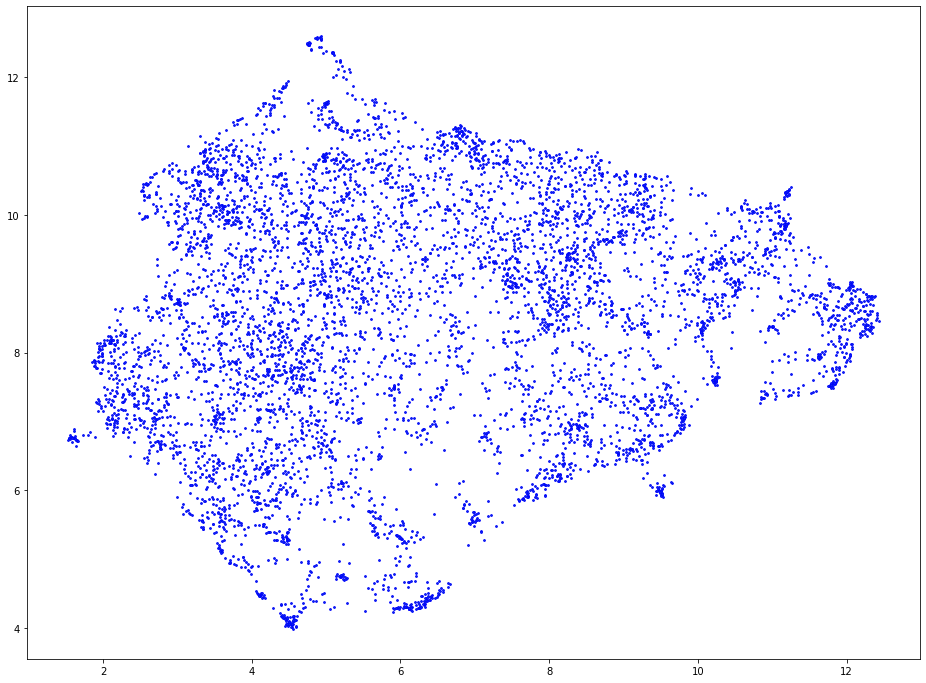

In [90]:
fig, ax = plt.subplots()
ax.scatter(sci_reduced[:, 0], sci_reduced[:, 1], 
           cmap=plt.cm.autumn, edgecolor='b', s=3)
plt.show()

In [91]:
%%time
# Кластеризуем, в среднем по два слова на кластер.
sci_clust_no = int(len(sci_vects)/2)
km_clustering = KMeans(n_clusters=sci_clust_no)
sci_clusters = km_clustering.fit_predict(sci_vects)

CPU times: user 8min 54s, sys: 10min 16s, total: 19min 11s
Wall time: 3min 16s


In [92]:
# Какие слова попадают в один кластер.
clust_no = 21

sci_words_sorted = sorted(zip(sci_clusters, sci_words), key= lambda x:x[0])
print([word[1] for word in sci_words_sorted if word[0]==clust_no])

['донный_ADJ', 'приповерхностный_ADJ', 'придонный_ADJ']


In [93]:
# Посчитаем координаты центроидов.
cur_clust = sci_words_sorted[0][0]
cur_coord = np.array(model_w2v[sci_words_sorted[0][1]])
cur_count = 1
clust_coord = []

for i, word in enumerate(sci_words_sorted[1:]):
    if cur_clust == sci_words_sorted[i+1][0]:
        cur_coord += model_w2v[sci_words_sorted[i+1][1]]
        cur_count += 1
    else:
        clust_coord.append(cur_coord/cur_count)
        cur_clust = sci_words_sorted[i+1][0]
        cur_coord = np.array(model_w2v[sci_words_sorted[i+1][1]])
        cur_count = 1
        
clust_coord.append(cur_coord/cur_count)


In [94]:
# Эта функция берет центры кластеров вместо слов.
sci_set = set(sci_words)
sci_words_d = {w[1]:w[0] for w in sci_words_sorted}

def text_to_vec_centr(text):
    text_vec = np.zeros((model_w2v.vector_size,), dtype="float32")
    n_words = 0

    for word in normalizePymorphy(text):
        if word in sci_words_d.keys():
            n_words = n_words + 1
            text_vec = np.add(text_vec, clust_coord[sci_words_d[word]]) 
        else:
            try:
                text_vec = np.add(text_vec, model_w2v[word]) 
                n_words = n_words + 1
            except Exception:
                pass
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec


In [95]:
# Строим вектора для слов.
sci_vect2 = []
for text in tqdm(sci_texts.Text):
    sci_vect2.append(text_to_vec_centr(text))

  0%|          | 0/5000 [00:00<?, ?it/s]

In [96]:
# Посмотрим как распределятся документы при таком подходе.
umap_sci=UMAP()
umaped_vct=umap_sci.fit_transform(sci_vect2)

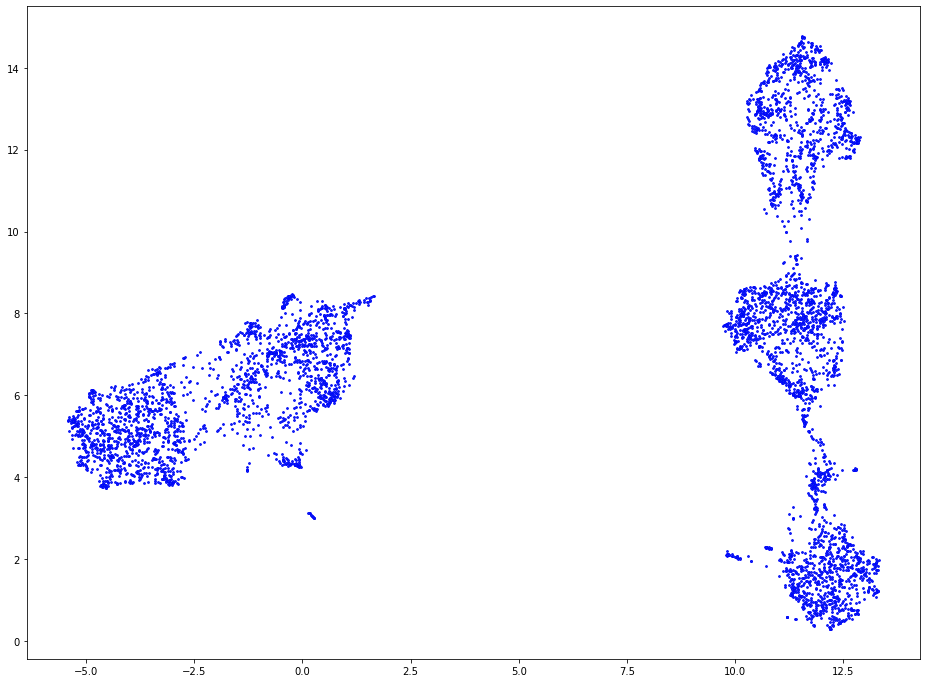

In [97]:
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

60


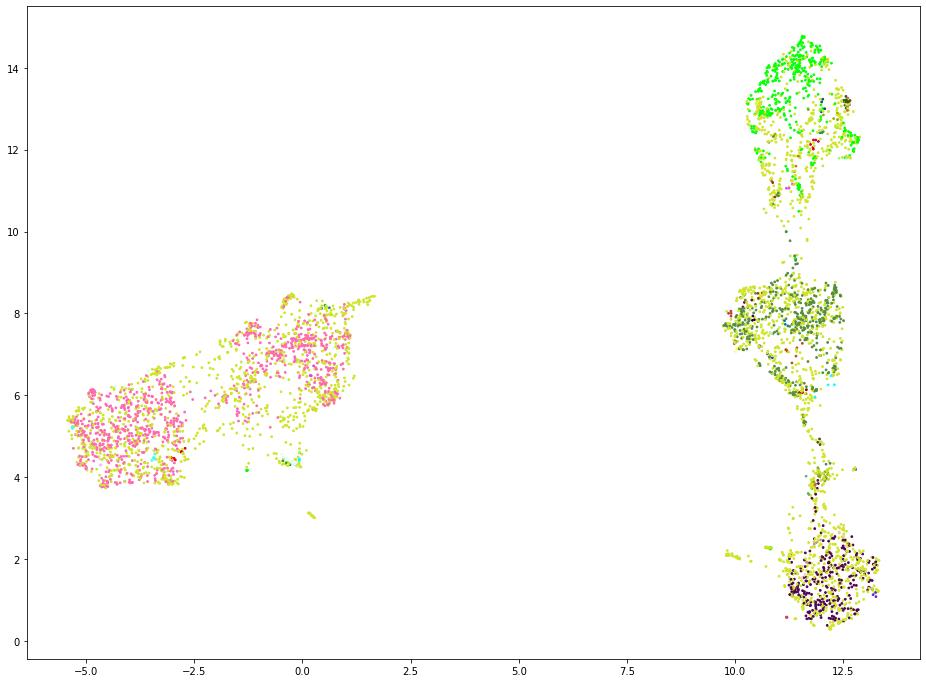

In [98]:
# Раскластеризуем документы.
db=DBSCAN(eps=0.08, min_samples=3)
db_clusters=db.fit_predict(sci_vect2)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
plt.show()

In [99]:
# Посмотрим на них глазами.
clusters=list(set(db_clusters))

for c in clusters[:10]:
    print('          __ ', c, ' __')
    cntr=0
    for i, a in enumerate(sci_texts.Text):
        if db_clusters[i]==c:
            print(a[:200])
            cntr+=1
            if cntr==3:
                break

          __  0  __
                                               ﻿удк 641.1/.3, 641.16                технологические аспекты показателя «активность воды» и его роль в обеспечении качества продукции общественного питан
                                               ﻿удк 641.1/.3, 641.16                технологические аспекты показателя «активность воды» и его роль в обеспечении качества продукции общественного питан
                                               ﻿проблемы формировйния и сохранения качества жененного мармепапа                табаторович а.н.,                аспирант сибирского университета потреби
          __  1  __
                                               ﻿оптимизация торгового ассортимента плавленых сыров с целью удовлетворения потребительских предпочтений                н.в. данилова                в свя
                                               ﻿оптимизация производственного ассортимента плавленых сыров на основе товарного консалтинга                н.

А теперь поступим по-другому. Разделим слова на 50 кластеров, а в качестве вектора признаков документа будем брать число слов данного документа, попадающих в каждый кластер.

In [100]:
%%time
cluster_space_size = 50
km_clustering = KMeans(n_clusters=cluster_space_size)
sci_clusters = km_clustering.fit_predict(sci_vects)

CPU times: user 28.2 s, sys: 16.1 s, total: 44.3 s
Wall time: 6.24 s


In [101]:
# Эта функция берет для документа количество слов по кластерам..
sci_set = set(sci_words)
sci_words_d = {w[1]:w[0] for w in sci_words_sorted}

def text_to_centoids(text):
    text_vec = np.zeros((cluster_space_size,), dtype="float32")
    n_words = 0

    for sent in normalizePymorphy(text):
        for word in sent:
            if word in sci_words_d.keys():
                n_words = n_words + 1
                text_vec[clust_coord[sci_words_d[word]]] += 1
    
    if np.sum(text_vec) != 0:
        text_vec /= np.sum(text_vec)
    return text_vec


In [102]:
clust_coord[sci_words_d['процесс_NOUN']]

array([ 4.04470e-02, -3.98800e-03,  1.11400e-03, -1.56500e-03,
        6.45370e-02, -7.96240e-02,  4.66350e-02, -3.29250e-02,
       -1.41430e-02,  8.69380e-02, -4.67300e-03, -5.26580e-02,
        1.37880e-02, -2.86750e-02, -5.35310e-02, -5.29950e-02,
        1.44490e-02, -7.23880e-02, -1.25670e-02, -5.48660e-02,
        5.29610e-02, -1.05060e-02,  2.49140e-02, -9.88500e-03,
       -1.52450e-02,  4.15680e-02,  5.18310e-02,  3.45090e-02,
       -7.86200e-03, -6.38200e-03, -8.40150e-02,  4.57990e-02,
       -2.89400e-03, -4.24810e-02,  1.44500e-02, -8.44400e-03,
       -9.77600e-03, -8.53950e-02, -1.62200e-02, -9.32930e-02,
        6.92100e-02, -1.57870e-02, -8.50000e-02, -3.09930e-02,
       -3.46800e-02, -7.84510e-02,  4.50060e-02, -2.52400e-02,
        8.62420e-02,  3.34210e-02,  5.05370e-02, -1.82630e-02,
       -7.30700e-03, -1.26520e-02, -2.34500e-03, -4.64850e-02,
        1.27570e-02,  2.96980e-02,  6.03150e-02, -1.21400e-02,
       -7.64200e-03, -9.79990e-02,  3.94980e-02, -2.060

In [103]:
# Эта функция берет для документа количество слов по кластерам..
sci_set = set(sci_words)
sci_words_d = {w[1]:w[0] for w in sorted(zip(sci_clusters, sci_words), key= lambda x:x[0])}

def text_to_centoids(text):
    text_vec = np.zeros((cluster_space_size,), dtype="float32")
    n_words = 0

    for word in text.split():
        if word in sci_words_d.keys():
            text_vec[sci_words_d[word]] += 1
    
    if np.sum(text_vec) != 0:
        text_vec /= np.sum(text_vec)
    return text_vec


In [104]:
# Строим вектора для слов.
sci_vect3 = []
for text in tqdm(sci_texts.NText):
    sci_vect3.append(text_to_centoids(text))

  0%|          | 0/5000 [00:00<?, ?it/s]

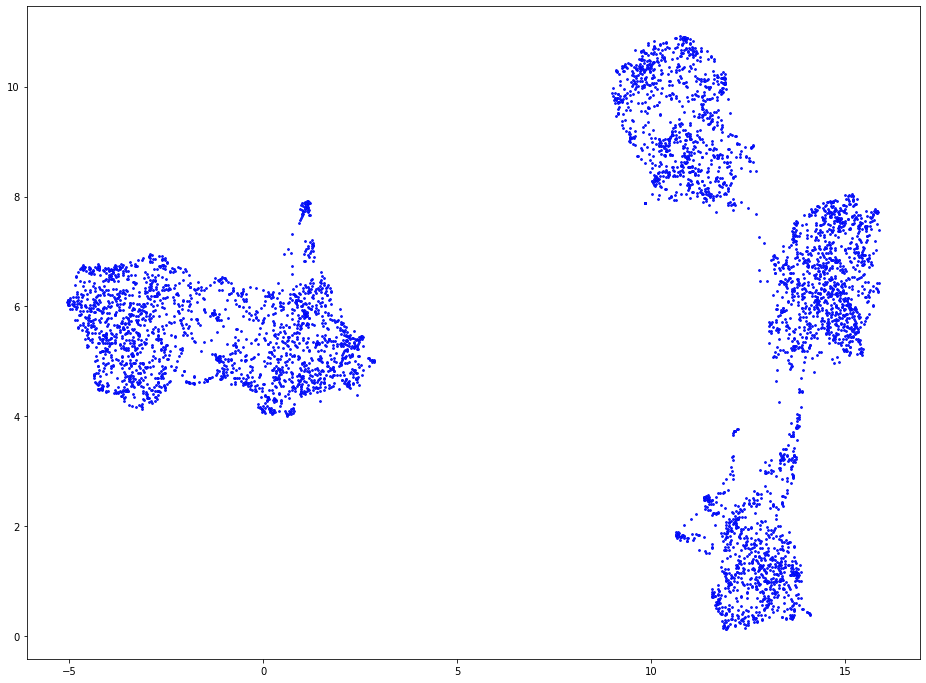

In [105]:
# Посмотрим как распределятся документы при таком подходе.
umap_sci=UMAP()
umaped_vct=umap_sci.fit_transform(sci_vect3)

fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], edgecolor='b', s=3)
plt.show()

70


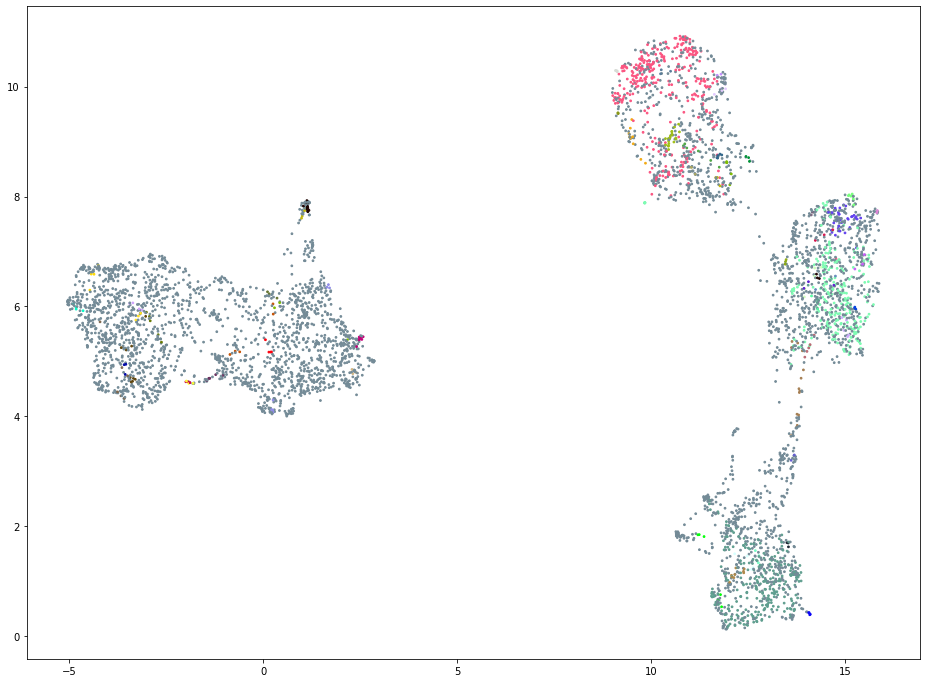

In [106]:
# Раскластеризуем документы.
db=DBSCAN(eps=0.075, min_samples=3)
db_clusters=db.fit_predict(sci_vect3)
myclr=ListedColormap(choice(list(sns.xkcd_rgb.values()), max(db_clusters)+1)) # Генерируем контрастную карту цветов.
print(max(db_clusters))
fig, ax = plt.subplots()
ax.scatter(umaped_vct[:, 0], umaped_vct[:, 1], s=3, c=db_clusters, cmap=myclr)
plt.show()

In [108]:
# Посмотрим на них глазами.
clusters=list(set(db_clusters))

for c in clusters[:10]:
    print(f'__ {c} __')
    cntr=0
    for i, a in enumerate(sci_texts.Text):
        if db_clusters[i]==c:
            print(a[:200])
            cntr+=1
            if cntr==3:
                break

__ 0 __
                                               ﻿удк 641.1/.3, 641.16                технологические аспекты показателя «активность воды» и его роль в обеспечении качества продукции общественного питан
                                               ﻿удк 641.1/.3, 641.16                технологические аспекты показателя «активность воды» и его роль в обеспечении качества продукции общественного питан
                                               ﻿удк 637.352                е.т. линкевич, и.р. зарипов                изучение технологических аспектов производства копченых полутвердых сыров         
__ 1 __
                                               ﻿оптимизация торгового ассортимента плавленых сыров с целью удовлетворения потребительских предпочтений                н.в. данилова                в свя
                                               ﻿оптимизация производственного ассортимента плавленых сыров на основе товарного консалтинга                н.в. данилова             

In [109]:
X_train, X_test, y_train, y_test = train_test_split(sci_vect3, classes, test_size=0.2, random_state=333)
tree = RandomForestClassifier(criterion='entropy', random_state=333)
tree.fit(X_train, y_train)
y_hat=tree.predict(X_test)
print(len([1 for i, j in zip(y_hat, y_test) if i==j])/len(y_test))
confusion_matrix(y_test, y_hat)

0.963


array([[197,   4,   7,   0,   1],
       [  2, 185,   3,   0,   0],
       [  6,   3, 194,   3,   0],
       [  0,   0,   0, 186,   7],
       [  0,   0,   0,   1, 201]])

-----

А теперь посмотрим на FastText.

In [110]:
from gensim.models.fasttext import FastText

In [51]:
#model_ft = KeyedVectors.load_fasttext_format('data/araneum_none_fasttextskipgram_300_5_2018.tgz', binary=True)

#model_ft = FastText.load('data/araneum_none_fasttextskipgram_300_5_2018.tgz')


In [111]:
tmp_dict2 = {} # Кеш значимых слов.

morph = pymorphy2.MorphAnalyzer()

# Фильтруем по части речи и возвращаем только начальную форму.
def normalizePymorphy3(text):
    output = []
    # Делим на предложения самым страшным из возможных образов.
    sentences = text.split('.')
    for sentence in sentences:
        tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', sentence)
        # Берем предложения не менее чем из 5 слов.
        if len(tokens)<=4:
            continue
        words = []
        for t in tokens:
            # Если токен уже был закеширован, быстро возьмем результат из него.
            if t in tmp_dict2.keys():
                words.append(tmp_dict2[t])
            # Слово еще не встретилось, будем проводить медленный морфологический анализ.
            else:
                pv = morph.parse(t)
                if pv[0].tag.POS != None:
                    # Отправляем слово в результат, ...
                    words.append(pv[0].normal_form)
                    # ... и кешируем результат его разбора.
                    tmp_dict2[t] = pv[0].normal_form
        output.append(words)
                    
    return output

In [112]:
all_sentences = []
for text in tqdm(news.News):
    all_sentences.extend(normalizePymorphy3(text))

  0%|          | 0/1708 [00:00<?, ?it/s]

In [114]:
%%time
# список параметров, которые можно менять по вашему желанию
num_features = 300  # итоговая размерность вектора каждого слова
min_word_count = 5  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 3     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели


model_ft = FastText(all_sentences, workers=num_workers, vector_size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

CPU times: user 19.9 s, sys: 1.75 s, total: 21.7 s
Wall time: 10.4 s


In [115]:
model_ft.init_sims(replace=True)

/tmp/ipykernel_393799/219246418.py:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model_ft.init_sims(replace=True)


In [116]:
model_ft.save("data/fast_text_news.bin")

In [117]:
model_ft = FastText.load("data/fast_text_news.bin")
#model_ft = FastText.load('data/araneum_none_fasttextskipgram_300_5_2018.tgz')
# Мне не хватило 16 Гб оперативной памяти, чтобы загрузить эту модель.
#model_ft = FastText.load_fasttext_format("data/cc.ru.300.bin.gz")

In [118]:
model_ft.wv['король_']-model_ft.wv['мужчина_']+model_ft.wv['женщина_']- model_ft.wv['королева_']


array([ 0.02371459, -0.01048715, -0.0270489 ,  0.01300185,  0.01777178,
        0.01834881,  0.02035419,  0.01355439, -0.00031965, -0.03762834,
        0.0570448 , -0.01739284, -0.02076318,  0.00501096, -0.00482356,
        0.01507597, -0.00537466, -0.00023278,  0.03428209,  0.00416109,
        0.04182412, -0.02270348,  0.01428392, -0.00099169,  0.00965798,
        0.00619522, -0.00069699,  0.00164337,  0.02515025, -0.06242841,
       -0.01504815,  0.00833768, -0.00851485,  0.00746039, -0.01334605,
        0.02753113, -0.00349931,  0.00714848, -0.01741816, -0.00459334,
       -0.02480294,  0.00288832, -0.00753802,  0.00785273,  0.04151852,
       -0.00558464, -0.00486442,  0.01806958, -0.01179049, -0.01219531,
        0.01841792, -0.00817893, -0.01381779,  0.01052645, -0.02821652,
       -0.04744896,  0.00861019,  0.02883787,  0.00692776, -0.01645585,
       -0.02286763,  0.00423228,  0.00598198,  0.003709  ,  0.03134623,
        0.03572293,  0.05438006,  0.01213864,  0.01051805, -0.01

In [119]:
from gensim.models import KeyedVectors # Семантические вектора.


In [120]:
#model_ft.wv.most_similar(positive=[u'пожар'])
#model_ft.wv.most_similar(positive=[u'пожар'], negative=[u'пламя'])
#model_ft.wv.most_similar(positive=[u'топливо_'], negative=[u'нефть_'])
#model_w2v.most_similar(positive=[u'женщина_NOUN', u'император_NOUN' ], negative=[u'мужчина_NOUN'])
#model_ft.most_similar(positive=[u'король_NOUN', u'женщина_NOUN'], negative=[u'мужчина_NOUN'])
#model_ft.most_similar(positive=[u'король_', u'женщина_'], negative=[u'мужчина_'])
#model_ft.most_similar(positive=[u'король', u'женщина'], negative=[u'мужчина'])
#model_ft.most_similar(positive=[u'президент', u'женщина'], negative=[u'мужчина'])
#model_ft.most_similar(negative=[u'король', u'мужчина'], positive=[u'женщина'])
#model_ft.most_similar(positive=[u'женщина_', u'король_'])
#model_ft.most_similar(positive=['германия_', 'москва_' ], negative=['берлин_'])
print(model_ft.wv.most_similar(positive=[u'король_', u'женщина_'], negative=[u'мужчина_']), "\n\n",
model_ft.wv.most_similar([model_ft.wv['король_']-model_ft.wv['мужчина_']+model_ft.wv['женщина_']]))

[('ка', 10.026437759399414), ('тема', 7.957744121551514), ('ан', 7.874449729919434), ('по', 7.083878517150879), ('материал', 6.535669803619385), ('олимпийский', 6.499141693115234), ('ник', 6.439122200012207), ('мать', 6.230875015258789), ('до', 6.216174125671387), ('кой', 6.0047149658203125)] 

 [('ка', 10.045478820800781), ('ан', 7.890819549560547), ('тема', 7.824236869812012), ('по', 7.004166603088379), ('олимпийский', 6.5339555740356445), ('ник', 6.461309432983398), ('материал', 6.444485664367676), ('до', 6.194974899291992), ('мать', 6.185122489929199), ('кой', 6.016816139221191)]


### Что осталось за кадром?

- BERT | ELMO (+ DeepPavlov)
- Онтологии.
- graph2vec (последовательность прослушанных песен, просмотр товаров, ...).